In [1]:
import numpy as np
import ROOT
from math import exp as expo
from math import cos as cosine
from math import sin as sine
sin=np.vectorize(sine)
exp=np.vectorize(expo)
cos=np.vectorize(cosine)
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
import scipy.optimize as opt

Welcome to JupyROOT 6.24/06


In [2]:
file_1 = ROOT.TFile.Open("run3a_NE_nbinshift_13.root")
hist_1 = ROOT.TH1D()
hcov_1 = ROOT.TH2D()
hist_1 = file_1.Get("calo_histogram_sum_ratio")
hcov_1 = file_1.Get("hcov")

file_2 = ROOT.TFile.Open("run3a_NE_nbinshift_14.root")
hist_2 = ROOT.TH1D()
hcov_2 = ROOT.TH2D()
hist_2 = file_2.Get("calo_histogram_sum_ratio")
hcov_2 = file_2.Get("hcov")

file_3 = ROOT.TFile.Open("run3a_NE_nbinshift_15.root")
hist_3 = ROOT.TH1D()
hcov_3 = ROOT.TH2D()
hist_3 = file_3.Get("calo_histogram_sum_ratio")
hcov_3 = file_3.Get("hcov")

file_4 = ROOT.TFile.Open("run3a_NE_nbinshift_16.root")
hist_4 = ROOT.TH1D()
hcov_4 = ROOT.TH2D()
hist_4 = file_4.Get("calo_histogram_sum_ratio")
hcov_4 = file_4.Get("hcov")



In [3]:
fit_start=30000
fit_stop=305000
fit_range=hist_1.FindBin(fit_stop)-hist_1.FindBin(fit_start)+1
y_val=np.empty(shape=(21,fit_range))
y_err=np.empty(shape=(21,fit_range))
x_val=np.empty(shape=(21,fit_range))
y_cov=np.empty(shape=(21,fit_range,fit_range))  

In [4]:
%%time
for ibin in range (0,fit_range):
    y_val[0][ibin]=hist_1.GetBinContent(ibin+hist_1.FindBin(fit_start))
    y_err[0][ibin]=hist_1.GetBinError(ibin+hist_1.FindBin(fit_start))
    x_val[0][ibin]=hist_1.GetBinCenter(ibin+hist_1.FindBin(fit_start))

for irow in range (0, fit_range):
    for icol in range(0, fit_range):
        y_cov[0][irow][icol]=hcov_1.GetBinContent(irow+hist_1.FindBin(fit_start),icol+hist_1.FindBin(fit_start))
        

for ibin in range (0,fit_range):
    y_val[1][ibin]=hist_2.GetBinContent(ibin+hist_2.FindBin(fit_start))
    y_err[1][ibin]=hist_2.GetBinError(ibin+hist_2.FindBin(fit_start))
    x_val[1][ibin]=hist_2.GetBinCenter(ibin+hist_2.FindBin(fit_start))

for irow in range (0, fit_range):
    for icol in range(0, fit_range):
        y_cov[1][irow][icol]=hcov_2.GetBinContent(irow+hist_2.FindBin(fit_start),icol+hist_2.FindBin(fit_start))
        

for ibin in range (0,fit_range):
    y_val[2][ibin]=hist_3.GetBinContent(ibin+hist_3.FindBin(fit_start))
    y_err[2][ibin]=hist_3.GetBinError(ibin+hist_3.FindBin(fit_start))
    x_val[2][ibin]=hist_3.GetBinCenter(ibin+hist_3.FindBin(fit_start))

for irow in range (0, fit_range):
    for icol in range(0, fit_range):
        y_cov[2][irow][icol]=hcov_3.GetBinContent(irow+hist_3.FindBin(fit_start),icol+hist_3.FindBin(fit_start))
        

for ibin in range (0,fit_range):
    y_val[3][ibin]=hist_4.GetBinContent(ibin+hist_4.FindBin(fit_start))
    y_err[3][ibin]=hist_4.GetBinError(ibin+hist_4.FindBin(fit_start))
    x_val[3][ibin]=hist_4.GetBinCenter(ibin+hist_4.FindBin(fit_start))

for irow in range (0, fit_range):
    for icol in range(0, fit_range):
        y_cov[3][irow][icol]=hcov_4.GetBinContent(irow+hist_4.FindBin(fit_start),icol+hist_4.FindBin(fit_start))
        



CPU times: user 24 s, sys: 5.48 s, total: 29.5 s
Wall time: 29.5 s


In [5]:
for icalo in range(0,4):
    mat=np.linalg.eigvalsh(y_cov[icalo])
    for irow in range (0, fit_range):
        if mat[irow]<=0:
            print(icalo,irow,"\n")

In [6]:
getBlinded = Blinders(FitType.Omega_a, "Ritwika's new  Blinding")

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [7]:
T_a_true=4365.411
nbinshift=int((0.5*T_a_true)/hist_2.GetBinWidth(1))
#T_a=2*nbinshift*hist_2.GetBinWidth(1)
T_a=13

asym=np.empty(4)
dasym=np.empty(4)
rval=np.empty(4)
drval=np.empty(4)
phi=np.empty(4)
dphi=np.empty(4)

calonum=np.empty(4)
red_chi2=np.empty(4)


In [8]:
def fit_func(time: np.double,
             asym: np.double = 0.0, 
             R: np.double = 0.0, 
             phi: np.double = 0.0,
             asym_cbo = 0.0,
             tau_cbo = 0.0,
             omega_cbo = 0.0,
             phi_cbo = 0.0)-> np.double:
    
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    
    f=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*time - phi))

    ff=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi))

    fb=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi))

    
    return (2*f*Ncbo - ff*Ncbof - fb*Ncbob)/(2*f*Ncbo + ff*Ncbof + fb*Ncbob)

In [9]:
p_init=[2.28839e-01,
        0.000000,
        4.02000e+00,
        2.42604e-03,
        2.54062e+05,
        2.330e-03,
        5.56481e-01]

In [10]:
%%time
for icalo in range(0,4): 
    
    p_init_final=p_init
    
    pars2, cov_final = opt.curve_fit(f=fit_func, xdata=x_val[icalo], ydata=y_val[icalo], p0=p_init_final, sigma=y_cov[icalo])
    
    
    stdevs=np.sqrt(np.diag(cov_final))
    
    chi2=np.dot((np.transpose(y_val[icalo]-fit_func(x_val[icalo], *pars2))),(np.dot((np.linalg.inv(y_cov[icalo])),(y_val[icalo]-fit_func(x_val[icalo], *pars2)))))
    red_chi2[icalo]=chi2/(fit_range-len(pars2))
    calonum[icalo]=icalo+1
    
    asym[icalo]=pars2[0]
    dasym[icalo]=stdevs[0]
    rval[icalo]=pars2[1]
    drval[icalo]=stdevs[1]
    phi[icalo]=pars2[2]
    dphi[icalo]=stdevs[2]
    
    
    p_init_final=pars2 
    T_a=T_a+1
    


/home/ritwika/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


CPU times: user 16.5 s, sys: 3.47 s, total: 19.9 s
Wall time: 8.91 s


In [11]:
nbinshift=[1.950,2.100,2.250,2.400]

In [12]:
len(rval)

4

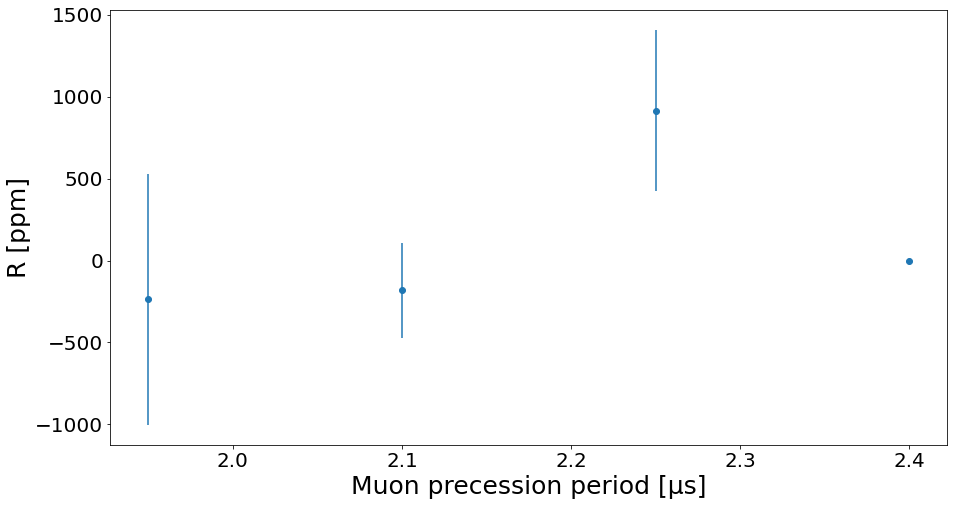

In [13]:
plt.figure(figsize=(15,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.errorbar(nbinshift, rval, yerr=drval, fmt="o")
plt.xlabel('Muon precession period [µs]',fontsize=25)
plt.ylabel('R [ppm]',fontsize=25)
plt.show()
#plt.savefig('run2_caloscan_R.jpg')

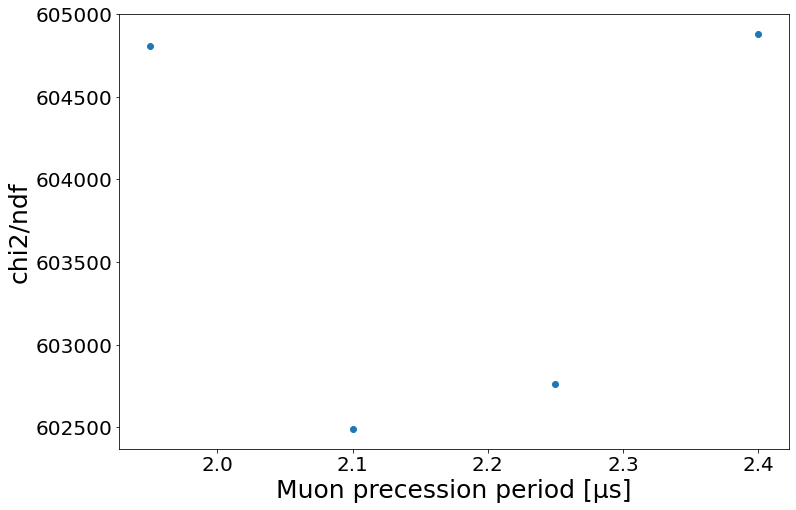

In [14]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.errorbar(nbinshift, red_chi2, yerr=0, fmt="o")
plt.xlabel('Muon precession period [µs]',fontsize=25)
plt.ylabel('chi2/ndf',fontsize=25)
plt.show()

In [15]:
rval

array([-2.36809224e+02, -1.82017679e+02,  9.15155556e+02, -7.17110180e-03])

In [16]:
drval

array([766.6687489 , 289.39142588, 493.10897666,          inf])

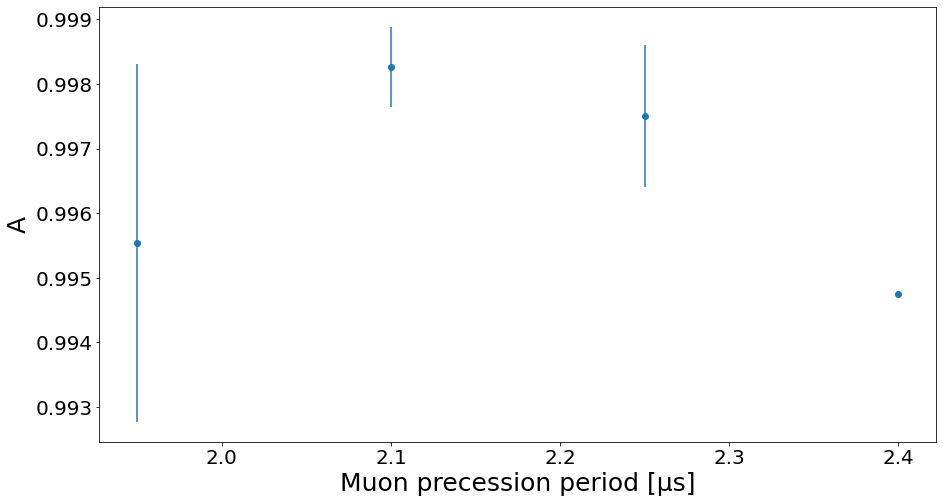

In [17]:
plt.figure(figsize=(15,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.errorbar(nbinshift, asym, yerr=dasym, fmt="o")
plt.xlabel('Muon precession period [µs]',fontsize=25)
plt.ylabel('A',fontsize=25)
plt.show()

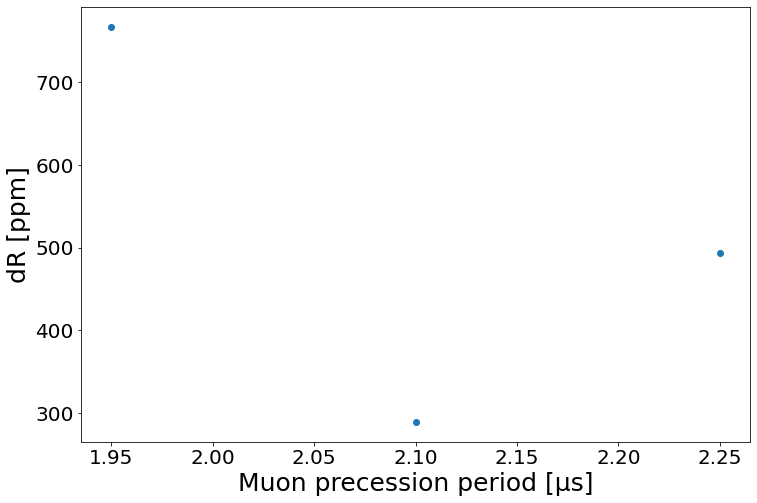

In [18]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.errorbar(nbinshift, drval, yerr=0, fmt="o")
plt.xlabel('Muon precession period [µs]',fontsize=25)
plt.ylabel('dR [ppm]',fontsize=25)
plt.show()

In [19]:
red_chi2

array([604809.23047843, 602488.29314859, 602763.74096489, 604881.49003426])